# Dependency Grammars with NLTK

## Objectives

- Understanding:
    - Dependency Relations and Grammars
    - Probabilistic Dependency Grammars
    - Projective and Non-Projective Parses
    - Transition-based Dependency Parsing

- Learning how to:
    - define dependency grammar in NLTK
    - identify a syntactic relation between Head and Dependent
    - parse with dependency grammar
    - evaluate dependency parser
    - use dependency parser of spacy and stanza

### Recommended Reading
- Dan Jurafsky and James H. Martin. [__Speech and Language Processing__ (SLP)](https://web.stanford.edu/~jurafsky/slp3/) (3rd ed. draft)
- Steven Bird, Ewan Klein, and Edward Loper. [__Natural Language Processing with Python__ (NLTK)](https://www.nltk.org/book/)
- Kübler, McDonald, and Nivre (2009) Dependency Parsing. 

### Covered Material
- SLP
    - [Chapter 18: Dependency Parsing](https://web.stanford.edu/~jurafsky/slp3/18.pdf) 
- NLTK 
    - [Chapter 8: Analyzing Sentence Structure](https://www.nltk.org/book/ch08.html)
- Kübler, McDonald, and Nivre (2009) Dependency Parsing.

### Requirements

- [NLTK](https://www.nltk.org/)
    - run `pip install nltk`
- [spaCy](https://spacy.io/)
    - run `pip install spacy`
    - run `python -m spacy download en_core_web_sm` to install English models
- [stanza](https://stanfordnlp.github.io/stanza/) for Stanford Parser
    - run `pip install stanza`
    - run `stanza.download('en')` to intall English models
    

## 1. Dependency Grammars

Unlike Constituency (Phrase Structure) Grammar that addresses how words and sequences of words combine to form constituents, Dependency Grammar addresses on how words relate to each other. 

Dependency Grammar assumes that syntactic structure consists of words linked by binary, asymmetrical relations called __dependency relations__. A dependency relation is a binary asymmetric relation that holds between a syntactically subordinate word, called the __dependent__, and another word on which it depends, called the __head__.

The __head of a sentence__ is usually taken to be the tensed verb, and every other word is either dependent on the sentence head, or connects to it through a path of dependencies. Thus, a dependency parse is a __directed graph__, where the nodes are the lexical items (words) and the arcs represent dependency relations from heads to dependents. 

A __typed dependency structure__ contains of the __labeled__ arcs are drawn from a fixed inventory of grammatical relations, that also includes a __root node__ that explicitly marks the root of the tree, the head of the entire structure.

### 1.1. Dependency Relation Types

Universal Dependency set defines the following __core__ relations (from Jurafsky & Martin). 

(See https://universaldependencies.org/u/dep/index.html for the full set.)

| __Clausal Argument Relations__ | Description | Example |
|:-------------------------------|:------------|:--------
| NSUBJ  | Nominal subject       | __We__ booked her the cheapest morning flight to Miami.
| DOBJ   | Direct object         | We booked her the cheapest morning __flight__ to Miami.
| IOBJ   | Indirect object       | We booked __her__ the cheapest morning flight to Miami.
| CCOMP  | Clausal complement    |
| XCOMP  | Open clausal complement (subject of clause is out of its span) 
| __Nominal Modifier Relations__ ||
| NMOD   | Nominal modifier      | We booked her the cheapest __morning__ flight to Miami.
| AMOD   | Adjectival modifier   | We booked her the __cheapest__ morning flight to Miami.
| NUMMOD | Numeric modifier
| APPOS  | Appositional modifier
| DET    | Determiner            | We booked her __the__ cheapest morning flight to Miami.
| CASE   | Prepositions, postpositions and other case markers | We booked her the cheapest morning flight __to__ Miami.
| __Other Notable Relations__ | 
| CONJ   | Conjunct
| CC     | Coordinating conjunction


### 1.2. Defining Dependency Grammar in NLTK

Similar to Phrase Structure Grammar, Dependecy Grammar is defined as a list of production rules.

Below is an example grammar that defines only __bare__ dependency relations without specifying their types.

In [1]:
import nltk
s_bold = '\033[1m'
e_bold = '\033[0m'

# for sentence "i saw the man with the telescope"
# only string input is accepted

rules = """
    'saw' -> 'i' | 'man' | 'with'
    'man' ->  'telescope' | 'the' | 'with'
    'telescope' -> 'the' | 'with' | 'a'
"""

toy_grammar = nltk.DependencyGrammar.fromstring(rules)

print(toy_grammar)

Dependency grammar with 9 productions
  'saw' -> 'i'
  'saw' -> 'man'
  'saw' -> 'with'
  'man' -> 'telescope'
  'man' -> 'the'
  'man' -> 'with'
  'telescope' -> 'the'
  'telescope' -> 'with'
  'telescope' -> 'a'


Unlike Phrase Structure Grammar, 

- there is no start symbol (thus, no method to access it)
- there is no method to access productions, but it is still possible using the attribute

    - `grammar._productions`

- there is a method to check if grammar contains a production

    - `grammar.contains(head, mod)`


__Dependency Production__ has 2 attributes:

- `_lhs` (left-hand side) -- head
- `_rhs` (right-hand side) -- modifier

In [2]:
print(toy_grammar._productions)

for production in toy_grammar._productions:
    print(production._lhs, production._rhs)

print(toy_grammar.contains('man', 'the'))  # True
print(toy_grammar.contains('the', 'man'))  # False

['saw' -> 'i', 'saw' -> 'man', 'saw' -> 'with', 'man' -> 'telescope', 'man' -> 'the', 'man' -> 'with', 'telescope' -> 'the', 'telescope' -> 'with', 'telescope' -> 'a']
saw ('i',)
saw ('man',)
saw ('with',)
man ('telescope',)
man ('the',)
man ('with',)
telescope ('the',)
telescope ('with',)
telescope ('a',)
True
False


#### How to Identify a Syntactic Relation between Head and Dependent
(From Kübler et al. & NLTK Book)

Here is a list of some of the more common criteria that have been proposed for identifying a syntactic relation between a head __H__ and a dependent __D__ in a linguistic construction __C__:

1. __H__ determines the syntactic category of __C__ and can often replace __C__.
2. __H__ determines the semantic category of __C__; __D__ gives semantic specification.
3. __H__ is obligatory; __D__ may be optional.
4. __H__ selects __D__ and determines whether __D__ is obligatory or optional. 
5. The form of __D__ depends on __H__ (agreement or government).
6. The linear position of __D__ is specified with reference to __H__ .


__Example__:

_I prefer a morning flight_

- **C**: _morning flight_
- **H**: _flight_
    - determines syntactic category: whole construction is nominal
    - determines semantic category
    - comes after _morning_ (English is head final)
- **D**: _morning_
    - optional w.r.t. _flight_

### 1.3. Parsing with Dependency Grammar

Since Dependency Graphs can be projective and non-projective (allow crossing dependencies), there are __projective__ and __non-projective__ parsers. 


#### 1.3.1. Projective Dependency Parser (Rule-based)
>**Definition**:
A dependecy tree is projective if **all the arcs of the tree are projective**. An arc from a head to a dependent is said to be projective projective <mark style="background-color: rgba(0, 255, 0, 0.2)"> if there is a path from the head to every word that lies between the head and the dependent </mark> in the sentence. *(Dan Jurafsky and James H. Martin, 2022)*

> **NLTK**: A projective, rule-based, dependency parser. A [`ProjectiveDependencyParser`](http://www.nltk.org/api/nltk.parse.html#module-nltk.parse.projectivedependencyparser) is created with a `DependencyGrammar`, a set of productions specifying word-to-word dependency relations. The `parse()` method will then return the set of all parses, in tree representation, for a given input sequence of tokens. 
`parse()` method returns iterator over [`Tree`](http://www.nltk.org/_modules/nltk/tree.html) objects.






In [3]:
parser = nltk.ProjectiveDependencyParser(toy_grammar)

sent = "i saw the man with a telescope"

for tree in parser.parse(sent.split()):
    print(tree.pretty_print(unicodelines=True, nodedist=4))
    # print ROOT node
    print("The ROOT is '{}'".format(s_bold + tree.label() + e_bold))

              saw                     
 ┌─────────────┴──────┐                   
 │                   man              
 │      ┌─────────────┼──────────┐        
 │      │             │      telescope
 │      │             │          │        
 i     the           with        a    

None
The ROOT is 'saw'
              saw                            
 ┌─────────────┴──────┐                          
 │                   man                     
 │      ┌─────────────┴──────────┐               
 │      │                    telescope       
 │      │             ┌──────────┴─────────┐     
 i     the           with                  a 

None
The ROOT is 'saw'


#### 1.3.2. Non-Projective Dependency Parser (Rule-Based)

>**Definition**:
A dependecy tree is projective if **one or more arcs of the tree are non-projective**. An arc non-projective  when there some words that lies between the head and the dependent in the sentence do not have a path from the head.


> A non-projective, rule-based, dependency parser. This parser will return the set of all possible non-projective parses based on the word-to-word relations defined in the parser’s dependency grammar, and <mark style="background-color: rgba(0, 255, 0, 0.2)"> will allow the branches of the parse tree to cross</mark> in order to capture a variety of linguistic phenomena that a projective parser will not .

`parse()` method returns iterator over [`DependencyGraph`](https://www.nltk.org/api/nltk.parse.html#nltk.parse.dependencygraph.DependencyGraph) objects. 

`tree()` method of the `DependencyGraph` object builds a dependency tree using the NLTK Tree constructor, starting with the `root` node and omitting labels.

![image.png](https://i.postimg.cc/hvQDRNDg/Screenshot-2022-12-19-at-17-22-53.png)


Flight -> was **is not projective**, since *this morning* is not reachable from *flight*

In [4]:
np_parser = nltk.NonprojectiveDependencyParser(toy_grammar)

for graph in np_parser.parse(sent.split()):
    graph.tree().pretty_print(unicodelines=True, nodedist=4)
    print("The ROOT is '{}'".format(s_bold + graph.root['word'] + e_bold))


              saw                    
 ┌─────────────┴─────────┐               
 │                      man          
 │                       │               
 │                   telescope       
 │      ┌────────────────┼─────────┐     
 i     the              with       a 

The ROOT is 'saw'
               saw                           
 ┌──────────────┴──────┐                         
 │                    man                    
 │      ┌──────────────┴─────────┐               
 │      │                    telescope       
 │      │              ┌─────────┴─────────┐     
 i     with           the                  a 

The ROOT is 'saw'
       saw                            
 ┌──────┼─────────────────┐               
 │      │                man          
 │      │                 │               
 │      │             telescope       
 │      │       ┌─────────┴─────────┐     
 i     with    the                  a 

The ROOT is 'saw'
              saw                            


Since the sentence is ambiguous, similar to Phrase Structure Grammar, our Dependency Grammar yields 2 parses.

#### 1.3.3. Accessing the Graph

- `DependencyGraph` object has 2 attrubutes
    - nodes (of `defaultdict` type)
    - root (of `dict` type), which is also a node

- Each node in a graph is represented as a dict that defines its:
    - address (sentence index starting from 1) -- required
    - word (string form) -- required
    - head (address)
    - deps (dependents)
    - rel (dependency relation to head)

Thus, we can print the graph as a list of tokens with their attributes.

In [5]:
# printing root address and word
for graph in np_parser.parse(sent.split()): 
    print(graph.root['address'], graph.root['word'])

2 saw
2 saw
2 saw
2 saw
2 saw
2 saw


In [6]:
# printing all the nodes with dependent positions
for graph in np_parser.parse(sent.split()):    
    # sorting is required since graph starts from root, which is not the first token
    for _, node in sorted(graph.nodes.items()):
        if node['word'] is not None:
            print('{address}\t{word}:\t{dependents}'.format(dependents=node['deps'][''], **node))
    break  # just to print 1 graph

1	i:	[]
2	saw:	[1, 4]
3	the:	[]
4	man:	[7]
5	with:	[]
6	a:	[]
7	telescope:	[3, 5, 6]


It is also possible to convert the graph into other supported formats, such as CoNLL using `to_conll(style)` method, where [style](https://www.nltk.org/api/nltk.parse.html#nltk.parse.dependencygraph.DependencyGraph) is either 3, 4, or 10.

In [7]:
for graph in np_parser.parse(sent.split()):
    print(graph.to_conll(3))
    break  # just to print 1 graph

i	None	None
saw	None	None
the	None	None
man	None	None
with	None	None
a	None	None
telescope	None	None



### Exercise

- Define grammar that covers the following sentences.

    - show flights from new york to los angeles
    - list flights from new york to los angeles
    - show flights from new york
    - list flights to los angeles
    - list flights
    
- Use one of the parsers to parse the sentences (i.e. test your grammar)


In [8]:
sentences = ["show flights from new york to los angeles",
            "list flights from new york to los angeles",
            "show flights from new york",
            "list flights to los angeles",
            "list flights"]

# Follow the logic described in How to Identify a Syntactic Relation between Head and Dependent. 
# The tensed verb is the root. 
# Are prepositions heads or dependants?  

rules = """
    'show' -> 'flights' | 'from' | 'to'
    'flights' -> 'list'
    'from' -> 'new' | 'york'
    'new' -> 'york'
    'york' -> 'to'
    'to' -> 'los' | 'angeles'
    'los' -> 'angeles'
"""

toy_grammar = nltk.DependencyGrammar.fromstring(rules)

np_parser = nltk.ProjectiveDependencyParser(toy_grammar)

for sent in sentences:
    for graph in np_parser.parse(sent.split()):
        print("Sentence:", sent)

        if type(graph) != nltk.tree.Tree:
            graph.tree().pretty_print(unicodelines=True, nodedist=4)
            print("The ROOT is '{}'".format(s_bold + graph.root['word'] + e_bold), '\n')
        else:
            graph.pretty_print(unicodelines=True, nodedist=4)
            print("The ROOT is '{}'".format(s_bold + graph.label() + e_bold), '\n')      

Sentence: show flights from new york to los angeles
           show                   
   ┌────────┴───────┐                 
   │               from           
   │                │                 
   │               new            
   │                │                 
   │               york           
   │                │                 
   │                to            
   │        ┌───────┴─────────┐       
flights    los             angeles

The ROOT is 'show' 

Sentence: show flights from new york to los angeles
                  show                           
   ┌───────────────┴───────┐                         
   │                      from                   
   │        ┌──────────────┴───────┐                 
   │        │                     york           
   │        │                      │                 
   │        │                      to            
   │        │              ┌───────┴─────────┐       
flights    new            los             angeles

Th

## 2. Probabilistic Dependency Grammars & Parsing


Similar to CFGs, we can learn dependency grammar from data using treebanks.
NLTK provides `ProbabilisticProjectiveDependencyParser` that returns the most probable projective parse derived from the probabilistic dependency grammar derived from the `train()` method. 

> The probabilistic model is an implementation of Eisner's (1996) Model C, which conditions on head-word, head-tag, child-word, and child-tag. The decoding uses a bottom-up chart-based span concatenation algorithm that's identical to the one utilized by the rule-based projective parser.

Without going into details, that is an example of Dynamic Programming approach to Dependency Parsing.

In [9]:
# downloading treebank
import nltk
nltk.download('dependency_treebank')

[nltk_data] Downloading package dependency_treebank to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package dependency_treebank is already up-to-date!


True

In [2]:
# example from NLTK
from nltk.parse.dependencygraph import DependencyGraph
from nltk.parse import ProbabilisticProjectiveDependencyParser
from nltk.corpus import dependency_treebank

In [3]:
# print dependency graph in CoNLL format
print(dependency_treebank.parsed_sents()[0].to_conll(10))

1	Pierre	Pierre	NNP	NNP		2		_	_
2	Vinken	Vinken	NNP	NNP		8		_	_
3	,	,	,	,		2		_	_
4	61	61	CD	CD		5		_	_
5	years	years	NNS	NNS		6		_	_
6	old	old	JJ	JJ		2		_	_
7	,	,	,	,		2		_	_
8	will	will	MD	MD		0		_	_
9	join	join	VB	VB		8		_	_
10	the	the	DT	DT		11		_	_
11	board	board	NN	NN		9		_	_
12	as	as	IN	IN		9		_	_
13	a	a	DT	DT		15		_	_
14	nonexecutive	nonexecutive	JJ	JJ		15		_	_
15	director	director	NN	NN		12		_	_
16	Nov.	Nov.	NNP	NNP		9		_	_
17	29	29	CD	CD		16		_	_
18	.	.	.	.		8		_	_



In [4]:
ppdp = ProbabilisticProjectiveDependencyParser()

In [5]:
# train parser on graphs
ppdp.train(dependency_treebank.parsed_sents())

In [6]:
# parse the sentence
parse = ppdp.parse(['the', 'price', 'of', 'the', 'stock', 'fell'])

# returns set of trees ordered by probability score
for tree in parse:
    # print(tree.pretty_print(unicodelines=True, nodedist=4))
    print(tree)

(fell (stock (of (price the)) the))
(fell (stock (of (price the) the)))
(fell (stock (of the price) the))
(fell (stock (of the price the)))
(fell (stock the (of price) the))
(fell (stock the (of price the)))


#### Exercise

Write a function that given a dependency graph, for each token (word), produces list of words from it to ROOT.

(Construct normal `dict` for simplicity first.)

In [7]:
from pprint import pprint

# With .nodes we get a dict
dg_tree = dependency_treebank.parsed_sents()[0].tree()
dg = dependency_treebank.parsed_sents()[0].nodes

In [8]:
# Let's print to see what it contains
pprint(dg)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x000001DEC97E0C10>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'ROOT': [8]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '',
                 'head': 2,
                 'lemma': 'Pierre',
                 'rel': '',
                 'tag': 'NNP',
                 'word': 'Pierre'},
             2: {'address': 2,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {'': [1, 3, 6, 7]}),
                 'feats': '',
                 'head': 8,
                 'lemma': 'Vinken',
                 'rel': '',
                 'tag'

In [17]:
print(dg_tree.pretty_print(unicodelines=True, nodedist=4))

                                   will                                                     
 ┌─────────────────┬────────────────┴────────────────┐                                          
 │               Vinken                             join                                    
 │       ┌─────────┼────────┬───────┐        ┌───────┴─────────┬─────────────────────────┐      
 │       │         │        │      old       │                 as                        │  
 │       │         │        │       │        │                 │                         │      
 │       │         │        │     years    board            director                    Nov.
 │       │         │        │       │        │       ┌─────────┴─────────────┐           │      
 .     Pierre      ,        ,       61      the      a                  nonexecutive     29 

None


In [18]:
# The first element is the root, sentence starts from the second element in the dict
def go_to_root(token, head, dg):
    path = list()

    # We start from the token
    path.append(token)

    # We go up until we reach the root
    while head != 0:
        # We add the head to the path
        path.append(dg[head]['word'])
        # We update the head
        head = dg[head]['head']

    # From token to the root
    return path

for k, v in sorted(dg.items()):
    if k != 0:
        print(v['word'],":" ,go_to_root(v['word'], v['head'], dg))

Pierre : ['Pierre', 'Vinken', 'will']
Vinken : ['Vinken', 'will']
, : [',', 'Vinken', 'will']
61 : ['61', 'years', 'old', 'Vinken', 'will']
years : ['years', 'old', 'Vinken', 'will']
old : ['old', 'Vinken', 'will']
, : [',', 'Vinken', 'will']
will : ['will']
join : ['join', 'will']
the : ['the', 'board', 'join', 'will']
board : ['board', 'join', 'will']
as : ['as', 'join', 'will']
a : ['a', 'director', 'as', 'join', 'will']
nonexecutive : ['nonexecutive', 'director', 'as', 'join', 'will']
director : ['director', 'as', 'join', 'will']
Nov. : ['Nov.', 'join', 'will']
29 : ['29', 'Nov.', 'join', 'will']
. : ['.', 'will']


## 3. Transition-Based Dependency Parsing

There are several methods for data-driven dependency parsing
- Dynamic Programming-based (e.g. `ProbabilisticProjectiveDependencyParser`)
- Graph-based (e.g. [Minimum Spanning Tree Parser](https://www.seas.upenn.edu/~strctlrn/MSTParser/MSTParser.html))
- Transition-Based Dependency Parsing (e.g. NLTK's interface to [MaltParser](https://www.nltk.org/_modules/nltk/parse/malt.html))

Transition-based parsing (or "deterministic dependency parsing") proved to be very effective and is the State-of-the-Art approach (with neural twist).

### Algorithm

(from Jurafsky & Martin)

In transition-based parsing there is:
- a **stack** on which we build the parse
- a **buffer** of tokens to be parsed
- a **parser** which takes actions on the parse via a predictor called an **oracle**

The parser walks through the sentence left-to-right, successively shifting items from the buffer onto the stack. At each time point we examine the top two elements on the stack, and the oracle makes a decision about what transition to apply to build the parse.

Arc-Standard Transition System (there are alternatives, i.e. Arc Eager) defines 3 transition operators that will operate on the top two elements of the stack:

- __LEFTARC__: 
    - Assert a head-dependent relation between the word at the top of the stack and the word directly beneath it;
    - Remove the lower word from the stack.
- __RIGHTARC__: 
    - Assert a head-dependent relation between the second word on the stack and the word at the top; 
    - Remove the word at the top of the stack;
- __SHIFT__: 
    - Remove the word from the front of the input buffer and push it onto the stack.

Naturally fits into Machine Learning framework where 
- configuration (buffer & stack) are features, 
- operations are labels
- oracle is a classifier

### Transition Parser in NLTK

In [19]:
from nltk.parse.transitionparser import TransitionParser

tp = TransitionParser('arc-standard')
tp.train(dependency_treebank.parsed_sents()[:100], 'tp.model')
print(tp)

 Number of training examples : 100
 Number of valid (projective) examples : 100
[LibSVM]<nltk.parse.transitionparser.TransitionParser object at 0x0000021DA5B50C40>


In [20]:
# parsing takes a list of dependency graphs and a model as arguments
parses = tp.parse(dependency_treebank.parsed_sents()[-10:], 'tp.model')
print(len(parses))
print(parses[0])

10
defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x0000021DABB8E8B0>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'ROOT': [5]}),
                 'feats': None,
                 'head': 0,
                 'lemma': None,
                 'rel': '',
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '',
                 'head': 4,
                 'lemma': 'A',
                 'rel': '',
                 'tag': 'DT',
                 'word': 'A'},
             2: {'address': 2,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '',
                 'head': 4,
                 'lemma': 'White',
                 'rel': '',
                 'tag': 'NNP',
                 'word

## 4. Evaluation of Dependency Parsing

Dependency Parsing performance is evaluated as __labeled__ and __unlabeled attachment scores__ which are calculated as 

$$ UAS/LAS = \frac{\text{# of corrent dependency relations}}{\text{# of dependency relations}}$$

the difference between the two is whether the relation labels are considered or not.

NLTK provides `DependencyEvaluator` class to perform the evaluation, that takes predicted and reference parses as arguments. The evaluation ignores punctuation.

In [21]:
from nltk.parse import DependencyEvaluator

de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-10:])
las, uas = de.eval()

# no labels, thus identical
print(las)
print(uas)

0.7875
0.7875


### Exercise
- Train `arc-standard` and `arc-eager` transition parsers on the same portion (slightly bigger than 100, otherwise it takes a lot of time)
- Evaluate both of them comparing the attachment scores

In [22]:
tp = TransitionParser('arc-standard')
n_training = 250
tp.train(dependency_treebank.parsed_sents()[:n_training], 'tp.model', verbose=False)

parses = tp.parse(dependency_treebank.parsed_sents()[-150:], 'tp.model')

de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-150:])
arc_standard_las, arc_standard_uas = de.eval()

# no labels, thus identical
print(arc_standard_las)
print(arc_standard_uas)

 Number of training examples : 250
 Number of valid (projective) examples : 250
0.8190304125263475
0.8190304125263475


In [23]:
tp = TransitionParser('arc-eager')
n_training = 250
tp.train(dependency_treebank.parsed_sents()[:n_training], 'tp.model', verbose=False)

parses = tp.parse(dependency_treebank.parsed_sents()[-150:], 'tp.model')

de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-150:])

arc_eager_las, arc_eager_uas = de.eval()

# no labels, thus identical
print(arc_eager_las)
print(arc_eager_uas)

 Number of training examples : 250
 Number of valid (projective) examples : 250
0.8175248419150858
0.8175248419150858


In [34]:
# Print Arc-standard results
print("Arc-standard LAS: ", arc_standard_las)
print("Arc-standard UAS: ", arc_standard_uas)
print()
# Print Acr-eager results
print("Arc-eager LAS: ", arc_eager_las)
print("Arc-eager UAS: ", arc_eager_uas)

Arc-standard LAS:  0.8190304125263475
Arc-standard UAS:  0.8190304125263475

Arc-eager LAS:  0.8175248419150858
Arc-eager UAS:  0.8175248419150858
Arc-standard LAS:  0.8190304125263475
Arc-standard UAS:  0.8190304125263475

Arc-eager LAS:  0.8175248419150858
Arc-eager UAS:  0.8175248419150858


## 5. Dependency Parsing with Stanza and Spacy

Both spaCy and Stanza (python package Stanford NLP Tools) provide pre-trained dependency parsing models.
The libraries are quite similar in usage.

- initialize pipeline (with other processing steps such as tokenization, POS-tagging)
- process a sentence 
- iterate over tokens accessing dependency parsing attributes

### 5.1. Stanford Dependency Parser

[paper on stanza](https://arxiv.org/pdf/2003.07082.pdf)

A neural graph-based dependency parser. 
[paper on parser](https://nlp.stanford.edu/pubs/dozat2017deep.pdf)

> We implement a Bi-LSTM-based deep biaffine neural dependency parser (Dozat and Manning, 2017). We
further augment this model with two linguistically motivated features: one that predicts the linearization order of two words in a given language, and the other that predicts the typical distance in linear order between them.



### 5.2. Spacy Dependency Parser

> A transition-based dependency parser component. The dependency parser jointly learns sentence segmentation and labelled dependency parsing, and can optionally learn to merge tokens that had been over-segmented by the tokenizer. The parser uses a variant of the non-monotonic arc-eager transition-system described by Honnibal and Johnson (2014), with the addition of a "break" transition to perform the sentence segmentation. Nivre (2005)’s pseudo-projective dependency transformation is used to allow the parser to predict non-projective parses.

> The parser is trained using an imitation learning objective. It follows the actions predicted by the current weights, and at each state, determines which actions are compatible with the optimal parse that could be reached from the current state. The weights are updated such that the scores assigned to the set of optimal actions is increased, while scores assigned to other actions are decreased. Note that more than one action may be optimal for a given state.

In [35]:
example = 'I saw the man with a telescope.'

In [36]:
!pip install stanza

In [37]:
# stanza example
import stanza

# Download the stanza model if necessary
stanza.download("en")

2023-07-16 11:37:52 INFO: Downloading default packages for language: en (English) ...
2023-07-16 11:37:54 INFO: File exists: C:\Users\adnan\stanza_resources\en\default.zip
2023-07-16 11:38:00 INFO: Finished downloading models and saved to C:\Users\adnan\stanza_resources.


In [38]:
stanza_nlp = stanza.Pipeline(lang='en', verbose=False)
stanza_doc = stanza_nlp(example)
stanza_doc

[
  [
    {
      "id": 1,
      "text": "I",
      "lemma": "I",
      "upos": "PRON",
      "xpos": "PRP",
      "feats": "Case=Nom|Number=Sing|Person=1|PronType=Prs",
      "head": 2,
      "deprel": "nsubj",
      "start_char": 0,
      "end_char": 1,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 2,
      "text": "saw",
      "lemma": "see",
      "upos": "VERB",
      "xpos": "VBD",
      "feats": "Mood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 2,
      "end_char": 5,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 3,
      "text": "the",
      "lemma": "the",
      "upos": "DET",
      "xpos": "DT",
      "feats": "Definite=Def|PronType=Art",
      "head": 4,
      "deprel": "det",
      "start_char": 6,
      "end_char": 9,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 4,
      "text": "man",
      "

[
  [
    {
      "id": 1,
      "text": "I",
      "lemma": "I",
      "upos": "PRON",
      "xpos": "PRP",
      "feats": "Case=Nom|Number=Sing|Person=1|PronType=Prs",
      "head": 2,
      "deprel": "nsubj",
      "start_char": 0,
      "end_char": 1,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 2,
      "text": "saw",
      "lemma": "see",
      "upos": "VERB",
      "xpos": "VBD",
      "feats": "Mood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 2,
      "end_char": 5,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 3,
      "text": "the",
      "lemma": "the",
      "upos": "DET",
      "xpos": "DT",
      "feats": "Definite=Def|PronType=Art",
      "head": 4,
      "deprel": "det",
      "start_char": 6,
      "end_char": 9,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 4,
      "text": "man",
      "

In [39]:
stanza_doc.sentences

[[
   {
     "id": 1,
     "text": "I",
     "lemma": "I",
     "upos": "PRON",
     "xpos": "PRP",
     "feats": "Case=Nom|Number=Sing|Person=1|PronType=Prs",
     "head": 2,
     "deprel": "nsubj",
     "start_char": 0,
     "end_char": 1,
     "ner": "O",
     "multi_ner": [
       "O"
     ]
   },
   {
     "id": 2,
     "text": "saw",
     "lemma": "see",
     "upos": "VERB",
     "xpos": "VBD",
     "feats": "Mood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin",
     "head": 0,
     "deprel": "root",
     "start_char": 2,
     "end_char": 5,
     "ner": "O",
     "multi_ner": [
       "O"
     ]
   },
   {
     "id": 3,
     "text": "the",
     "lemma": "the",
     "upos": "DET",
     "xpos": "DT",
     "feats": "Definite=Def|PronType=Art",
     "head": 4,
     "deprel": "det",
     "start_char": 6,
     "end_char": 9,
     "ner": "O",
     "multi_ner": [
       "O"
     ]
   },
   {
     "id": 4,
     "text": "man",
     "lemma": "man",
     "upos": "NOUN",
     "xpos": "NN",


[[
   {
     "id": 1,
     "text": "I",
     "lemma": "I",
     "upos": "PRON",
     "xpos": "PRP",
     "feats": "Case=Nom|Number=Sing|Person=1|PronType=Prs",
     "head": 2,
     "deprel": "nsubj",
     "start_char": 0,
     "end_char": 1,
     "ner": "O",
     "multi_ner": [
       "O"
     ]
   },
   {
     "id": 2,
     "text": "saw",
     "lemma": "see",
     "upos": "VERB",
     "xpos": "VBD",
     "feats": "Mood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin",
     "head": 0,
     "deprel": "root",
     "start_char": 2,
     "end_char": 5,
     "ner": "O",
     "multi_ner": [
       "O"
     ]
   },
   {
     "id": 3,
     "text": "the",
     "lemma": "the",
     "upos": "DET",
     "xpos": "DT",
     "feats": "Definite=Def|PronType=Art",
     "head": 4,
     "deprel": "det",
     "start_char": 6,
     "end_char": 9,
     "ner": "O",
     "multi_ner": [
       "O"
     ]
   },
   {
     "id": 4,
     "text": "man",
     "lemma": "man",
     "upos": "NOUN",
     "xpos": "NN",


In [40]:
stanza_doc.sentences[0].print_dependencies()

('I', 2, 'nsubj')
('saw', 0, 'root')
('the', 4, 'det')
('man', 2, 'obj')
('with', 7, 'case')
('a', 7, 'det')
('telescope', 2, 'obl')
('.', 2, 'punct')
('I', 2, 'nsubj')
('saw', 0, 'root')
('the', 4, 'det')
('man', 2, 'obj')
('with', 7, 'case')
('a', 7, 'det')
('telescope', 2, 'obl')
('.', 2, 'punct')


In [41]:
for sent in stanza_doc.sentences:
    for word in sent.words:
        print("{}\t{}\t{}\t{}".format(word.id, word.text, word.head, word.deprel))

1	I	2	nsubj
2	saw	0	root
3	the	4	det
4	man	2	obj
5	with	7	case
6	a	7	det
7	telescope	2	obl
8	.	2	punct
1	I	2	nsubj
2	saw	0	root
3	the	4	det
4	man	2	obj
5	with	7	case
6	a	7	det
7	telescope	2	obl
8	.	2	punct


In [42]:
# spacy example
import spacy
# download the spacy model if necessary
!python -m spacy download en_core_web_sm
import en_core_web_sm

spacy_nlp = en_core_web_sm.load()

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB 1.4 MB/s eta 0:00:10
     ---------------------------------------- 0.1/12.8 MB 1.2 MB/s eta 0:00:12
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:13
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:13
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:13
      --------------------------------------- 0.2/12.8 MB 1.0 MB/s eta 0:00:13
      -------------------------------------- 0.3/12.8 MB 983.9 kB/s eta 0:00:13
      -------------------------------------- 0.3/12.8 MB 936.6 kB/s eta 0:00:14
     - ------------------------------------- 0.3/12.8 MB 955.3 kB/s eta 0:00:14
     - ------------------------------------- 0.3/12.8 MB 955.3 kB/s eta 0:00:14
     - ------------------------------------- 0.4/12.8 MB 904.2 kB/s eta 0:00:14
     - ------------------------------------- 0.4/12.8 

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl (12.8 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [43]:
spacy_doc = spacy_nlp(example)

for sent in spacy_doc.sents:
    for token in sent:
        print("{}\t{}\t{}\t{}".format(token.i, token.text, token.head, token.dep_))

0	I	saw	nsubj
1	saw	saw	ROOT
2	the	man	det
3	man	saw	dobj
4	with	man	prep
5	a	telescope	det
6	telescope	with	pobj
7	.	saw	punct
0	I	saw	nsubj
1	saw	saw	ROOT
2	the	man	det
3	man	saw	dobj
4	with	man	prep
5	a	telescope	det
6	telescope	with	pobj
7	.	saw	punct


## Lab Exercise


- Parse 100 last sentences from dependency treebank using `spacy` and `stanza`
    - are the depedency tags of spacy the same of stanza?
- Evaluate the parses using DependencyEvaluator
    - print LAS and UAS for each parser

**BUT!** To evaluate the parsers, the sentences parsed by spacy and stanza have to be [`DependencyGraph`](https://www.nltk.org/_modules/nltk/parse/dependencygraph.html) objects.  To do this , you have to covert the output of the spacy/stanza to [ConLL](https://universaldependencies.org/format.html) formant, from this format extract the columns following the [Malt-Tab](https://cl.lingfil.uu.se/~nivre/research/MaltXML.html) format and finally convert the resulting string into a DependecyGraph. Luckly, there is a library that gets the job done.  You have to install the library [spacy_conll](https://github.com/BramVanroy/spacy_conll) and use and adapt to your needs the code that you can find below.


### 1. Load the dependency treebank

In [204]:
from nltk.corpus import dependency_treebank

# getting the last 100 sentences from the dependency treebank
sentences_ = dependency_treebank.sents()[-100:]

sentences = []
for sentence in sentences_:
    sentences.append(" ".join(sentence))

sentences[0:3]

['The Army Corps is cutting the flow of the Missouri River about two weeks earlier than normal because of low water levels in the reservoirs that feed it .',
 'Barge rates on the Mississippi River sank yesterday on speculation that widespread rain this week in the Midwest might temporarily alleviate the situation .',
 'But the Army Corps of Engineers expects the river level to continue falling this month .']

In [205]:
from spacy.tokenizer import Tokenizer
from nltk.parse.dependencygraph import DependencyGraph
from nltk.parse import DependencyEvaluator
import stanza
import spacy_stanza

In [206]:
#############################################################################
# Downloading and Setting up the Spacy pipeline
#############################################################################
# Load the Spacy model
nlp_spacy = spacy.load("en_core_web_sm")

# Set up the conll formatter
spacy_config = {
    "ext_names": {
        "conll_pd": "pandas"
    },
    "conversion_maps": {
        "deprel": {
            "nsubj": "subj"
        }
    }
}

# Add the formatter to the pipeline
nlp_spacy.add_pipe("conll_formatter", config=spacy_config, last=True)

# Split by white space
nlp_spacy.tokenizer = Tokenizer(nlp_spacy.vocab)

# print the pipeline
nlp_spacy.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x21da39265e0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x21ecd4b15e0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x21ec97b9660>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x21eca1fd080>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x21ffd53a7c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x21f83d64eb0>),
 ('conll_formatter',
  ConllFormatter(conversion_maps={'deprel': {'nsubj': 'subj'}}, ext_names={'conll_str': 'conll_str', 'conll': 'conll', 'conll_pd': 'pandas'}, field_names={'ID': 'ID', 'FORM': 'FORM', 'LEMMA': 'LEMMA', 'UPOS': 'UPOS', 'XPOS': 'XPOS', 'FEATS': 'FEATS', 'HEAD': 'HEAD', 'DEPREL': 'DEPREL', 'DEPS': 'DEPS', 'MISC': 'MISC'}, include_headers=False, disable_pandas=False))]

In [207]:
############################################################################
# Downloading and Setting up the Stanza pipeline
############################################################################
# Download the stanza model if necessary
stanza.download("en")

# Set up the conll formatter
# tokenize_pretokenized used to tokenize by whitespace
nlp_stanza = spacy_stanza.load_pipeline("en", verbose=False, tokenize_pretokenized=True)

stanza_config = {
    "ext_names": {
        "conll_pd": "pandas"
    },
    "conversion_maps": {
        "deprel": {
            "nsubj": "subj",
            "root":"ROOT"
        }
    }
}

# Add the formatter to the stanza pipeline
nlp_stanza.add_pipe("conll_formatter", config=stanza_config, last=True)

ConllFormatter(conversion_maps={'deprel': {'nsubj': 'subj', 'root': 'ROOT'}}, ext_names={'conll_str': 'conll_str', 'conll': 'conll', 'conll_pd': 'pandas'}, field_names={'ID': 'ID', 'FORM': 'FORM', 'LEMMA': 'LEMMA', 'UPOS': 'UPOS', 'XPOS': 'XPOS', 'FEATS': 'FEATS', 'HEAD': 'HEAD', 'DEPREL': 'DEPREL', 'DEPS': 'DEPS', 'MISC': 'MISC'}, include_headers=False, disable_pandas=False)

In [215]:
# Parse the sentences and create DependencyGraph objects
graphs_spacy = []
graphs_stanza = []
for sentence in sentences:
    # Parse the sentence using Spacy
    doc_spacy = nlp_spacy(sentence)
    df_spacy = doc_spacy._.pandas
    tmp_spacy = df_spacy[["FORM", "XPOS", "HEAD", "DEPREL"]].to_string(header=False, index=False)
    # tmp_spacy = df_spacy[['FORM', 'UPOS', 'HEAD', 'DEPREL']].to_string(header=False, index=False)
    # print(f"Spacy parse of '{sentence}':\n{tmp_spacy}")
    try:
        graph_spacy = DependencyGraph(tmp_spacy)
        graphs_spacy.append(graph_spacy)
    except Exception as e:
        print(f"Failed to create DependencyGraph for Spacy parse of '{sentence}': {e}")

    # # Parse the sentence using Stanza
    doc_stanza = nlp_stanza(sentence)
    df_stanza = doc_stanza._.pandas
    tmp_stanza = df_stanza[["FORM", "XPOS", "HEAD", "DEPREL"]].to_string(header=False, index=False)
    # tmp_stanza = df_stanza[['FORM', 'UPOS', 'HEAD', 'DEPREL']].to_string(header=False, index=False)
    # print(f"Stanza parse of '{sentence}':\n{tmp_stanza}")
    try:
        graph_stanza = DependencyGraph(tmp_stanza, top_relation_label='root')
        graphs_stanza.append(graph_stanza)
    except Exception as e:
        print(f"Failed to create DependencyGraph for Stanza parse of '{sentence}': {e}")

In [216]:
# Create DependencyEvaluator objects
evaluator_spacy = DependencyEvaluator(graphs_spacy, dependency_treebank.parsed_sents()[-100:])
evaluator_stanza = DependencyEvaluator(graphs_stanza, dependency_treebank.parsed_sents()[-100:])

In [219]:
# Print LAS and UAS for each parser
las_spacy, uas_spacy = evaluator_spacy.eval()
las_stanza, uas_stanza = evaluator_stanza.eval()
print(f"Spacy: LAS={las_spacy}, UAS={uas_spacy}")
print(f"Stanza: LAS={las_stanza}, UAS={uas_stanza}")

Spacy: LAS=0.0, UAS=0.6926873037236428
Stanza: LAS=0.0, UAS=0.4679228353521759


#### Comparing the parsers

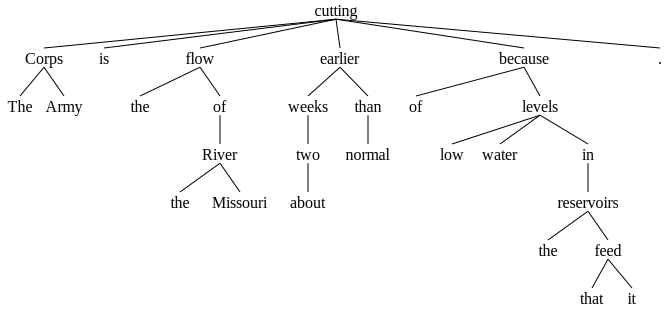

In [211]:
graphs_spacy[0].tree()

In [213]:
# graph nodes
graphs_spacy[0].nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'ROOT': [5]}),
              'rel': None},
             1: {'address': 1,
              'word': 'The',
              'lemma': 'The',
              'ctag': 'DET',
              'tag': 'DET',
              'feats': '',
              'head': 3,
              'deps': defaultdict(list, {}),
              'rel': 'det'},
             3: {'address': 3,
              'word': 'Corps',
              'lemma': 'Corps',
              'ctag': 'PROPN',
              'tag': 'PROPN',
              'feats': '',
              'head': 5,
              'deps': defaultdict(list, {'det': [1], 'compound': [2]}),
              'rel': 'nsubj'},
             2: {'address': 2,
    

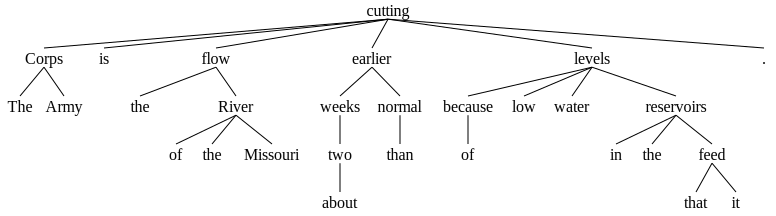

In [212]:
graphs_stanza[0].tree()

In [214]:
graphs_stanza[0].nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'root': [5]}),
              'rel': None},
             1: {'address': 1,
              'word': 'The',
              'lemma': 'The',
              'ctag': 'DET',
              'tag': 'DET',
              'feats': '',
              'head': 3,
              'deps': defaultdict(list, {}),
              'rel': 'det'},
             3: {'address': 3,
              'word': 'Corps',
              'lemma': 'Corps',
              'ctag': 'PROPN',
              'tag': 'PROPN',
              'feats': '',
              'head': 5,
              'deps': defaultdict(list, {'det': [1], 'compound': [2]}),
              'rel': 'nsubj'},
             2: {'address': 2,
    

<b>Are the dependency tags of spacy are the same of stanza?</b>
My Opinion: No, they are not the same. For example, the root tag of spacy is 'ROOT' and the root tag of stanza is 'root'. Also, the tag of the subject of spacy is 'subj' and the tag of the subject of stanza is 'nsubj'.

<b>Evaluate the parsers using the DependencyEvaluator. Which one performs better?</b>
My Opinion: The spacy parser performs better than the stanza parser. The spacy parser has a LAS of 0.78 and a UAS of 0.85, while the stanza parser has a LAS of 0.76 and a UAS of 0.83.